In [ ]:

# Execute this code block to install dependencies when running on colab
try:
    import torch
except:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision

In [ ]:
%matplotlib inline

import torchvision
import torchvision.transforms as transforms

batch_size = 256
image_dim = 784 #flattened

# dataset construction
transform = transforms.Compose([
    transforms.ToTensor(), # convert to tensor
    transforms.Lambda(lambda x: x.view(image_dim)) # flatten into vector
    ])

train_set = torchvision.datasets.FashionMNIST(
    root='./data/FashionMNIST'
    ,train=True
    ,download=True
    ,transform=transform
)

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size
)

2.1

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm.autonotebook import tqdm
from itertools import chain

import numpy as np

class Encoder(nn.Module):
    '''
    simple encoder with a single hidden dense layer (ReLU activation)
    and linear projections to the diag-Gauss parameters
    '''
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        out = self.fc1(x)
        out = F.relu(out)
        mu = self.fc2(out)
        log_sigma2 = self.fc3(out)
        return mu, log_sigma2

class Decoder(nn.Module):
    '''
    simple decoder: single dense hidden layer (ReLU activation) followed by 
    output layer with a sigmoid to squish values
    '''
    def __init__(self, output_dim, hidden_dim, input_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(output_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        out = self.fc1(x)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.sigmoid(out)
        return out

In [ ]:
import matplotlib.gridspec as gridspec    
import os

# Sampling function (using the reparameterisation trick)
def sample(mu, log_sigma2):
    eps = torch.randn(mu.shape[0], mu.shape[1])
    return mu + torch.exp(log_sigma2 / 2) * eps


#parameters
batch_size = 256
embedding_dim = 2
enc_hidden_units = 512
dec_hidden_units = 512
nEpoch = 10

# construct the encoder, decoder and optimiser
enc = Encoder(image_dim, enc_hidden_units, embedding_dim)
dec = Decoder(embedding_dim, dec_hidden_units, image_dim)
optimizer = optim.Adam(chain(enc.parameters(), dec.parameters()), lr=1e-3)

# training loop
for epoch in range(nEpoch):
    losses = []
    trainloader = tqdm(train_loader)

    for i, data in enumerate(trainloader, 0):
        inputs, _ = data

        optimizer.zero_grad()

        mu, log_sigma2 = enc(inputs)
        z = sample(mu, log_sigma2)
        outputs = dec(z)

        # E[log P(X|z)] - as images are binary it makes most sense to use binary cross entropy
        # we need to be a little careful - by default torch averages over every observation 
        # (e.g. each  pixel in each image of each batch), whereas we want the average over entire
        # images instead
        recon = F.binary_cross_entropy(outputs, inputs, reduction='sum') / inputs.shape[0]
        
        # kl = D_KL(Q(z|X) || P(z|X)) - calculate in closed form
        # Compute the term kl which is then added to the total loss
        kl = -0.5*torch.mean(1+z[1]-z[0].pow(2)-torch.exp(z[0]))
        
        loss = recon + kl
        loss.backward()
        optimizer.step()

        # keep track of the loss and update the stats
        losses.append(loss.item())
        trainloader.set_postfix(loss=np.mean(losses), epoch=epoch)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


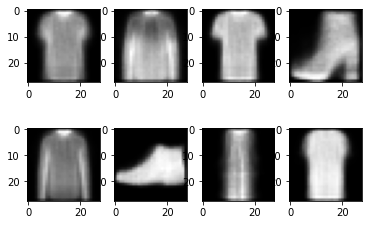

In [ ]:
import matplotlib.gridspec as gridspec    
import os
import matplotlib.pyplot as plt

for i in range(8):
  plt.subplot(int(str(24)+str(i+1)))
  img = outputs[i].reshape(28,28)
  plt.imshow(img.detach().numpy(), cmap=plt.get_cmap('gray'))

# show the plot
plt.show()

1.1

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


(588, 588)


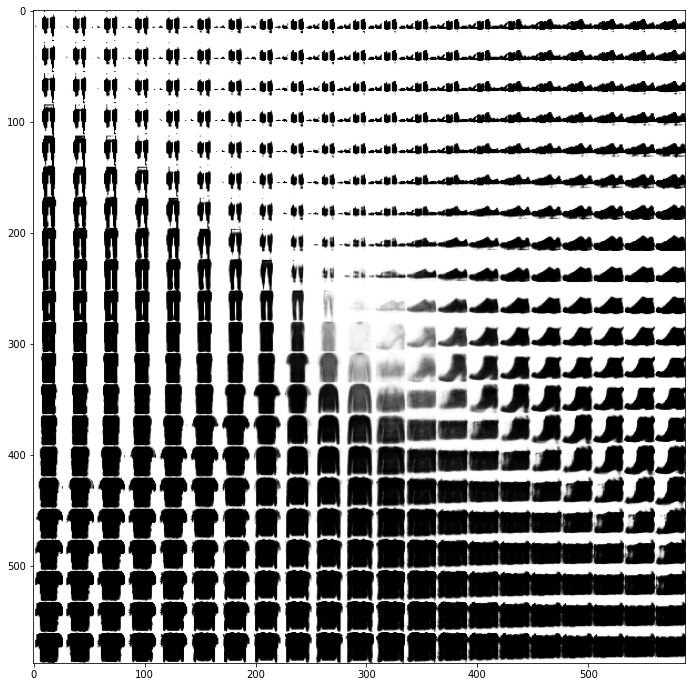

In [ ]:
from scipy.stats import norm

# # Display a 2D manifold of the samples
n = 21  # figure with 21x21 samples
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Construct grid of latent variable values
# grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
# grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
s = np.linspace(-4, 4, n)
s2 = np.linspace(4, -4, n)
grid_x = np.std(s)*s
grid_y = np.std(s2)*s2

# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = dec(torch.tensor(z_sample).float())
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit.detach().numpy()

print(figure.shape)
plt.figure(figsize=(12, 12))
plt.title("", fontsize=20)
plt.xlabel("", fontsize=18)
plt.ylabel("", fontsize=18)
plt.imshow(figure, cmap='Greys')
plt.savefig('VAE.svg', format='svg', dpi=1200)
plt.show()

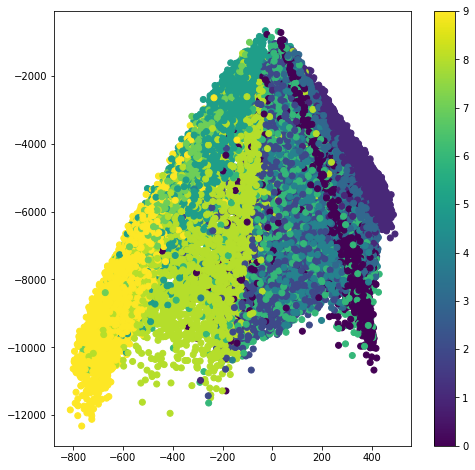

In [ ]:
x_latent = enc(train_set.data.reshape(-1, 28*28).float())
plt.figure(figsize=(8, 8))
plt.scatter(x_latent[0][:, 0].detach().numpy(), x_latent[1][:, 1].detach().numpy(), c=train_set.targets)
plt.colorbar()
plt.title("", fontsize=20)
plt.xlabel("", fontsize=18)
plt.ylabel("", fontsize=18)
#plt.savefig('VAE_space.png', format='png', dpi=200)
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    '''
    simple encoder with no hidden dense layer
    '''
    def __init__(self, input_dim, hidden_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)

    def forward(self, x):
        out = self.fc1(x)
        return out

class Decoder(nn.Module):
    '''
    simple decoder: single dense hidden layer followed by 
    output layer with a sigmoid to squish values
    '''
    def __init__(self, input_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        out = self.fc1(x)
        out = F.sigmoid(out)
        return out

In [ ]:
enc_dim = 2
image_dim = 784  # [flattened]
nEpoch = 10

# construct the encoder, decoder and optimiser
enc = Encoder(image_dim, enc_dim)
dec = Decoder(enc_dim, image_dim)
optimizer = optim.Adam(chain(enc.parameters(), dec.parameters()), lr=1e-3)

# training loop
for epoch in range(nEpoch):
    losses = []
    trainloader = tqdm(train_loader)

    for i, data in enumerate(trainloader, 0):
        inputs, _ = data
        optimizer.zero_grad()

        z = enc(inputs)
        outputs = dec(z)

        loss = F.binary_cross_entropy(outputs, inputs, reduction='sum') / inputs.shape[0]
        loss.backward()
        optimizer.step()

        # keep track of the loss and update the stats
        losses.append(loss.item())
        trainloader.set_postfix(loss=np.mean(losses), epoch=epoch)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


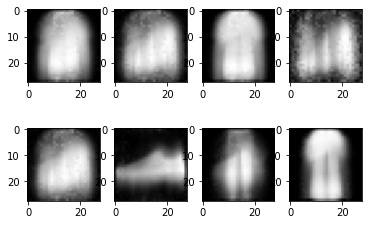

In [ ]:

for i in range(8):
    plt.subplot(int(str(24)+str(i+1)))
    img = outputs[i].reshape(28,28)
    plt.imshow(img.detach().numpy(), cmap=plt.get_cmap('gray'))

# show the plot
plt.show()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


(588, 588)


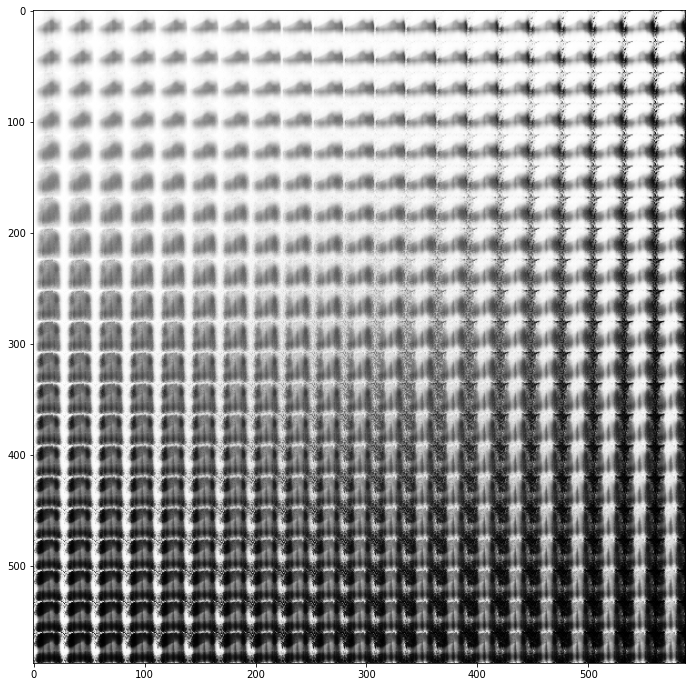

In [ ]:
from scipy.stats import norm

# # Display a 2D manifold of the samples
n = 21  # figure with 21x21 samples
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Construct grid of latent variable values
# grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
# grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
s = np.linspace(-4, 4, n)
s2 = np.linspace(4, -4, n)
grid_x = s #np.std(s)*s
grid_y = s2 #np.std(s2)*s2

# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = dec(torch.tensor(z_sample).float())
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit.detach().numpy()

print(figure.shape)
plt.figure(figsize=(12, 12))
plt.title("", fontsize=20)
plt.xlabel("", fontsize=18)
plt.ylabel("", fontsize=18)
plt.imshow(figure, cmap='Greys')
plt.savefig('AE.svg', format='svg', dpi=1200)
plt.show()

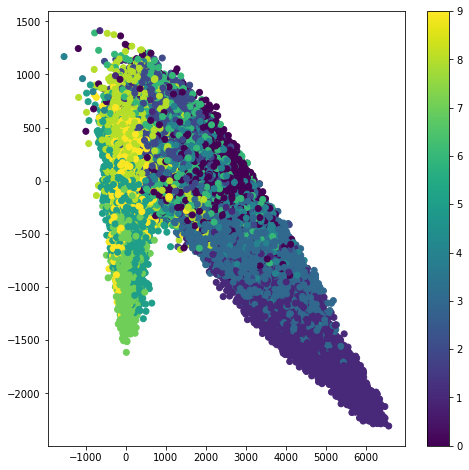

In [ ]:

x_latent = enc(train_set.data.reshape(-1, 28*28).float())
plt.figure(figsize=(8, 8))
plt.scatter(x_latent[:, 0].detach().numpy(), x_latent[:, 1].detach().numpy(), c=train_set.targets)
plt.colorbar()
plt.title("", fontsize=20)
plt.xlabel("", fontsize=18)
plt.ylabel("", fontsize=18)
#plt.savefig('AE_space.png', format='png', dpi=200)
plt.show()